<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W4/ungraded_labs/C1_W4_Lab_1_image_generator_no_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training with ImageDataGenerator

In this lab, you will build a train a model on the [Horses or Humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset. This contains over a thousand images of horses and humans with varying poses and filesizes. You will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to prepare this dataset so it can be fed to a convolutional neural network.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

Run the code below to download the compressed dataset `horse-or-human.zip`.

In [8]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2023-09-30 20:57:42--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.207, 108.177.120.207, 142.250.103.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip.1’

horse-or-human.zip. 100%[===================>] 142.65M   218MB/s    in 0.7s    

2023-09-30 20:57:43 (218 MB/s) - ‘horse-or-human.zip.1’ saved [149574867/149574867]



You can then unzip the archive using the [zipfile](https://docs.python.org/3/library/zipfile.html) module.

In [9]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory `./horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like' and 'this is what a human looks like'.

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. You will use the ImageDataGenerator API instead -- and this is coded to automatically label images according to the directory names and structure. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. `ImageDataGenerator` will label the images appropriately for you, reducing a coding step.

You can now define each of these directories:

In [10]:
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

Now see what the filenames look like in the `horses` and `humans` training directories:

In [11]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse06-4.png', 'horse36-9.png', 'horse41-7.png', 'horse18-7.png', 'horse46-0.png', 'horse13-6.png', 'horse02-8.png', 'horse02-3.png', 'horse11-6.png', 'horse28-1.png']
['human13-03.png', 'human08-27.png', 'human04-27.png', 'human04-15.png', 'human11-30.png', 'human14-26.png', 'human08-25.png', 'human10-08.png', 'human14-03.png', 'human07-17.png']


You can also find out the total number of horse and human images in the directories:

In [12]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

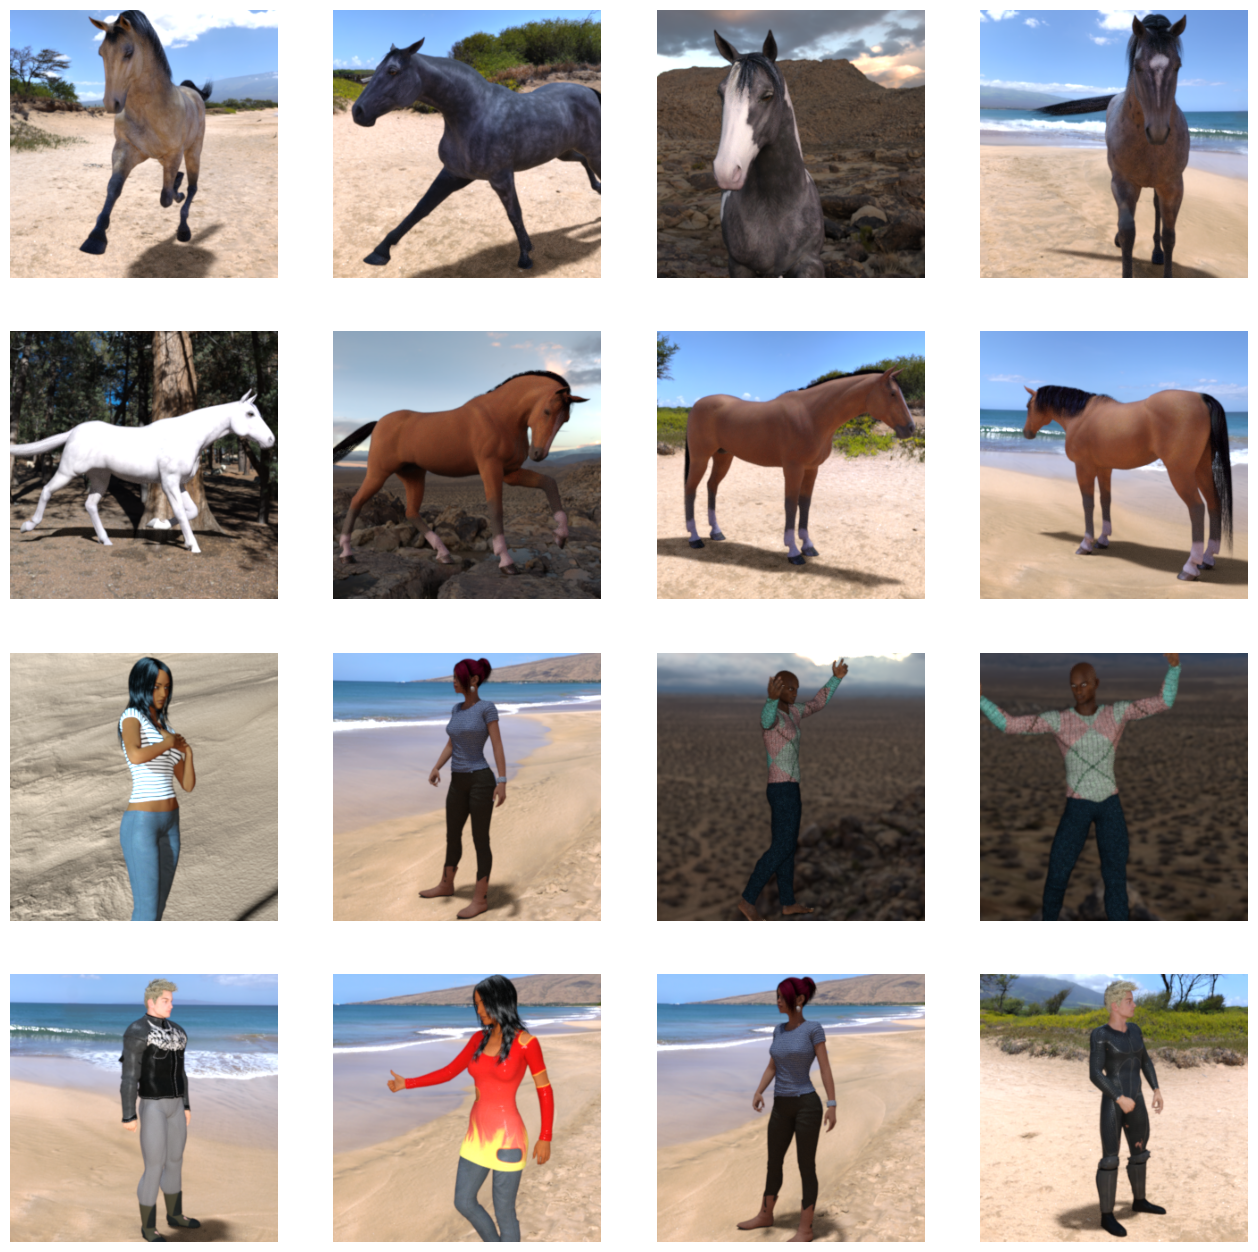

In [14]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

Now you can define the model architecture that you will train.

Step 1 will be to import tensorflow.

In [15]:
import tensorflow as tf

You then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers. Note that because this is a two-class classification problem, i.e. a *binary classification problem*, you will end your network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). This makes the output value of your network a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [16]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can review the network architecture and the output shapes with `model.summary()`.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

The "output shape" column shows how the size of your feature map evolves in each successive layer. As you saw in an earlier lesson, the convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.

Next, you'll configure the specifications for model training. You will train the model with the [`binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss because it's a binary classification problem, and the final activation is a sigmoid. (For a refresher on loss metrics, see this [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) You will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, you will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [18]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

Optimizers are used to minimize loss by checking prediction against the label to reach its minimum loss close to zero 0. The learning rate is used to adjust the steps taken to reach its minimum.

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### Training

You can start training for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses.

In [20]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 22s 704ms/step - loss: 0.6954 - accuracy: 0.5640
Epoch 2/15
8/8 [==============================] - 6s 758ms/step - loss: 0.9039 - accuracy: 0.6452
Epoch 3/15
8/8 [==============================] - 7s 769ms/step - loss: 0.5131 - accuracy: 0.7508
Epoch 4/15
8/8 [==============================] - 7s 854ms/step - loss: 0.5009 - accuracy: 0.7909
Epoch 5/15
8/8 [==============================] - 6s 756ms/step - loss: 0.5450 - accuracy: 0.7720
Epoch 6/15
8/8 [==============================] - 6s 755ms/step - loss: 0.2099 - accuracy: 0.9210
Epoch 7/15
8/8 [==============================] - 7s 819ms/step - loss: 0.1716 - accuracy: 0.9310
Epoch 8/15
8/8 [==============================] - 7s 824ms/step - loss: 0.1547 - accuracy: 0.9399
Epoch 9/15
8/8 [==============================] - 6s 762ms/step - loss: 0.2079 - accuracy: 0.9166
Epoch 10/15
8/8 [==============================] - 7s 789ms/step - loss: 0.0956 - accuracy: 0.9622
Epoch 11/15
8/8 [=

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

In [21]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


Saving animal-4071342_640.jpg to animal-4071342_640.jpg
Saving arabian-horse-4270748_640.jpg to arabian-horse-4270748_640.jpg
Saving girl2.jpg to girl2.jpg
Saving girl-510451_640.jpg to girl-510451_640.jpg
Saving horse-3611921_640.jpg to horse-3611921_640.jpg
Saving mountain-5092625_640.jpg to mountain-5092625_640.jpg
Saving white-horse-3010129_1280.jpg to white-horse-3010129_1280.jpg
Saving woman-4820889_640.jpg to woman-4820889_640.jpg
Saving woman-4906077_640.jpg to woman-4906077_640.jpg
1/1 [==============================] - 0s 306ms/step
[0.03786758]
animal-4071342_640.jpg is a horse
1/1 [==============================] - 0s 20ms/step
[4.369192e-09]
arabian-horse-4270748_640.jpg is a horse
1/1 [==============================] - 0s 20ms/step
[0.6662495]
girl2.jpg is a human
1/1 [==============================] - 0s 21ms/step
[4.0066266e-06]
girl-510451_640.jpg is a horse
1/1 [==============================] - 0s 22ms/step
[4.848094e-13]
horse-3611921_640.jpg is a horse
1/1 [=======

If you're using Safari and the cell above throws an error, you will need to upload the images(s) manually in their workspace.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below.

In [23]:
# # CODE BLOCK FOR OLD VERSIONS OF SAFARI

# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = load_img(path, target_size=(300, 300))
#  x = img_to_array(img)
#  x /= 255
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a human")
#  else:
#    print(i + " is a horse")

### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 [==============================] - 0s 156ms/step


<ipython-input-24-6a1089b7fa5c>:45: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


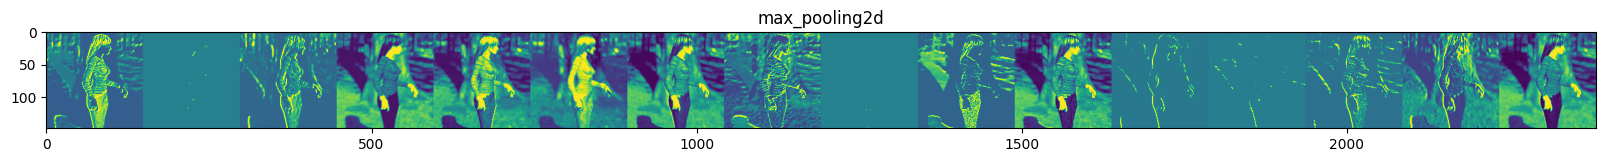

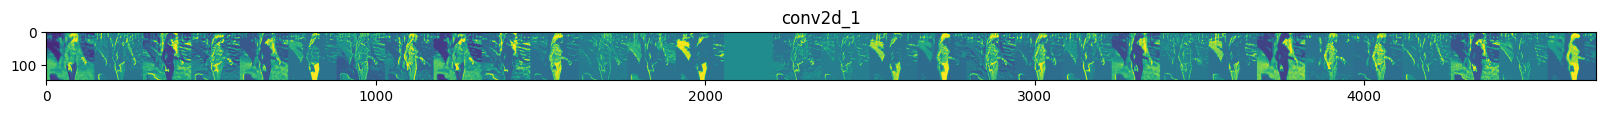

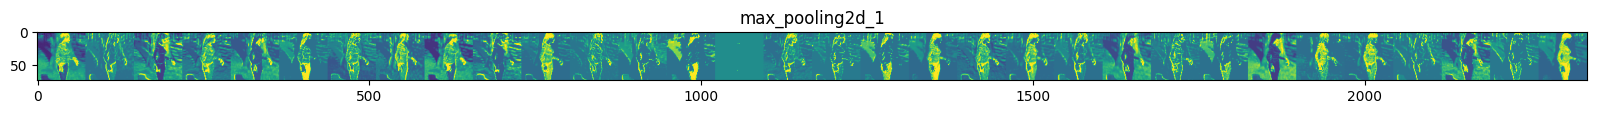

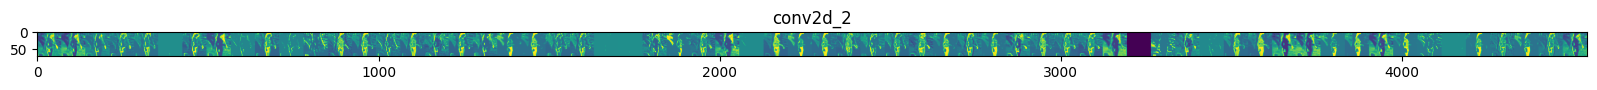

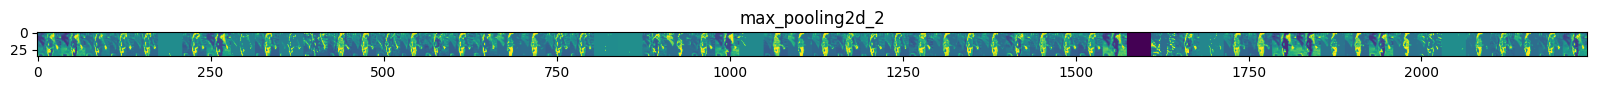

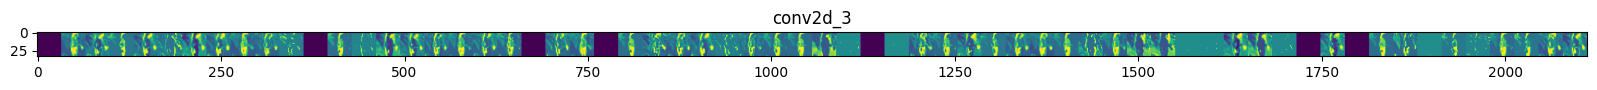

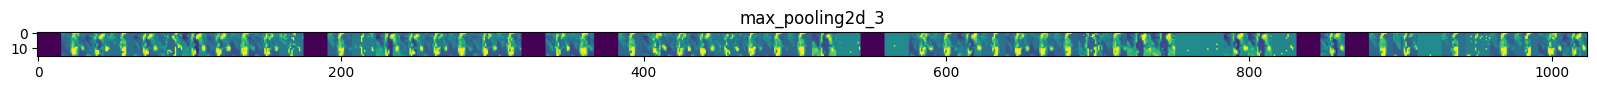

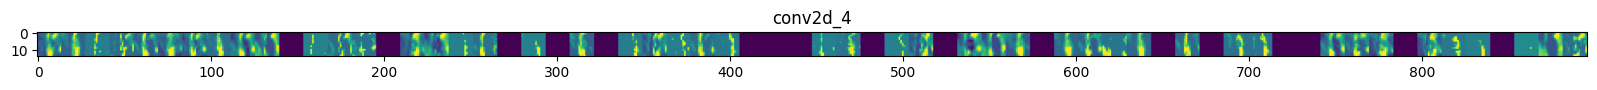

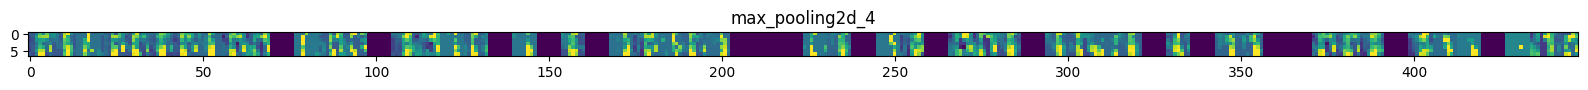

In [24]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

## Clean Up

You will continue with a similar exercise in the next lab but before that, run the following cell to terminate the kernel and free memory resources:

In [ ]:
from google.colab import runtime
runtime.unassign()